# Introduction to JAX

_JAX is a Python library for accelerator-oriented array computation and program transformation, designed for high-performance numerical computing and large-scale machine learning._

Additional resources:
- Getting started with JAX (notebooks + videos): https://github.com/gordicaleksa/get-started-with-JAX
- JAX tutorials: https://jax.readthedocs.io/en/latest/tutorials.html

If you want to run this notebook locally, follow the instructions here https://jax.readthedocs.io/en/latest/installation.html). For full GPU support, use JAX on a Linux platform with NVIDIA GPU. Otherwise, use Google Colab.

## Basic concepts: JAX vs NumPy

JAX's syntax is similar to NumPy's, so that many JAX functions can be used as drop-in replacement to NumPy's functions.

In [9]:
# Imports for this lesson
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import jax
from jax import random, device_put, jit, grad, vmap, make_jaxpr

Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
2024-07-10 14:13:26.338387: W pjrt_plugin/src/mps_client.cc:563] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


Metal device set to: Apple M2 Pro


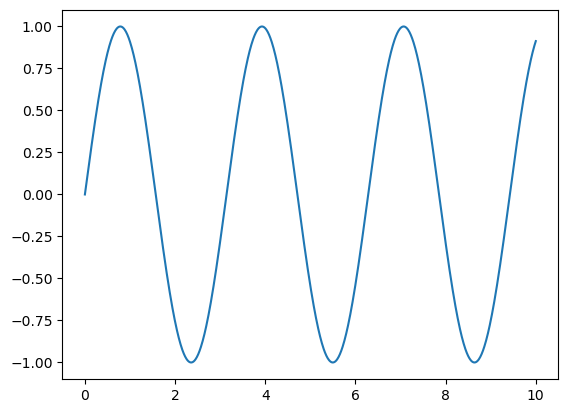

In [2]:
x_np = jnp.linspace(0, 10, 1000)
y_np = 2 * jnp.sin(x_np) * jnp.cos(x_np)
plt.plot(x_np, y_np)

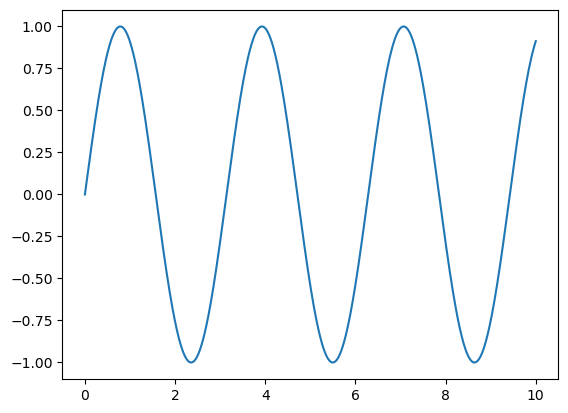

In [3]:
# Equivalent NumPy code
x_np = np.linspace(0, 10, 1000)
y_np = 2 * np.sin(x_np) * np.cos(x_np)
plt.plot(x_np, y_np)

Differently from NumPy, JAX arrays are **immutable**. This is because JAX requires that programs are *pure functions*, to simplify analysis and perform better optimization.

When a *pure function* is called with some given arguments, it will always return the same result, and cannot be affected by any mutable state or other side effects (we will talk more about this later).

In [4]:
size = 10
index = 0
value = 23

# In NumPy arrays are mutable
x = np.arange(size)
print(x)
x[index] = value
print(x)

[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


In [5]:
# In JAX we have to deal with immutable arrays
x = jnp.arange(size)
print(x)
x[index] = value
print(x)

[0 1 2 3 4 5 6 7 8 9]


TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [6]:
# Solution/workaround:
y = x.at[index].set(value)
print(x)
print(y)
# The updated array is returned as a new array and the original array is not modified by the update.
# In some cases, JAX can optimize this and avoid copying (see jit).

[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


JAX is accelerator (hardware) agnostic. Same code runs everywhere!

In [10]:
# Print the default device used for JAX computations
default_device = jax.devices()[0]
print("Default device:", default_device)

# Print the default backend used for JAX computations
default_backend = jax.default_backend()
print("Default backend:", default_backend)

Default device: METAL:0
Default backend: METAL


In [11]:
size = 3000

key = random.key(42)

# Data is automatically pushed to the accelerator! (DeviceArray structure)
# NOTE: by default, JAX arrays are float32, while NumPy arrays are float64.
x_jnp = random.normal(key, (size, size), dtype=jnp.float32)
x_np = np.random.normal(size=(size, size)).astype(np.float32)

%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready()  # 1) on GPU - fast
%timeit np.dot(x_np, x_np.T)  # 2) on CPU - slow (NumPy only works with CPUs)
%timeit jnp.dot(x_np, x_np.T).block_until_ready()  # 3) on GPU with transfer overhead

x_np_device = device_put(x_np)  # push NumPy explicitly to GPU
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready()  # same as 1)

# Note 1: I'm using GPU as a synonym for accelerator. 
# In reality, especially in Colab, this can also be a TPU, etc.

# Note 2: block_until_ready() -> asynchronous dispatch (https://jax.readthedocs.io/en/latest/async_dispatch.html)

12.2 ms ± 40.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
68.9 ms ± 766 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
18 ms ± 9.64 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.3 ms ± 117 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Due to JAX's accelerator agnostic approach, out-of-bounds indexing results in errors, rather than exceptions. 

In [12]:
# NumPy behavior

try:
  np.arange(10)[11]
except Exception as e:
    print("Exception {}".format(e))

Exception index 11 is out of bounds for axis 0 with size 10


In [13]:
# JAX behavior
# 1) updates at out-of-bounds indices are skipped
# 2) retrievals result in index being clamped
# in general there are currently some bugs so just consider the behavior undefined!

print(jnp.arange(10).at[11].add(23))  # example of 1)
print(jnp.arange(10)[11])  # example of 2)

[0 1 2 3 4 5 6 7 8 9]
0


## Transformations

## `vmap`: automatic vectorization

In NN and numerical computations we frequently write functions that operate on batches of data (i.e. multiple samples of some features). `vmap` helps to generate a _vectorized_ implementation of a function automatically, without going through manual, error-prone and inefficient vectorization. You can then write functions operating on single samples and then vectorize them.

In [14]:
W = random.normal(key, (150, 100))  # e.g. weights of a linear NN layer
batched_x = random.normal(key, (10, 100))  # e.g. a batch of 10 flattened images

# Function operating on a single sample
def apply_matrix(x):
    return jnp.dot(W, x)  # (150, 100) * (100, 1) -> (150, 1) (1 sample)

In [15]:
def naively_batched_apply_matrix(batched_x):
    return jnp.stack([apply_matrix(x) for x in batched_x]) # stack results in a column vector

print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched
1.98 ms ± 39.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [16]:
print(naively_batched_apply_matrix(batched_x).shape)

(10, 150)


In [17]:
def batched_apply_matrix(batched_x):
    return jnp.dot(batched_x, W.T)  # (10, 100) * (100, 150) -> (10, 150)

print('Manually batched')
%timeit batched_apply_matrix(batched_x).block_until_ready()
# We can make it even faster with jit... See below

Manually batched
269 µs ± 1.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Use the parameters `in_axes` and `out_axes` to specify which input array axes to map over and where the mapped axis should appear in the output.

In [18]:
# Example: implementing matrix-matrix product by vectorizing the dot product
vv = lambda x, y: jnp.vdot(x, y)  #  ([a], [a]) -> []
mv = vmap(vv, (0, None), 0)      #  ([b,a], [a]) -> [b]      (b is the mapped axis, i.e. axis 0 of first input)
mm = vmap(mv, (None, 1), 1)      #  ([b,a], [a,c]) -> [b,c]  (c is the mapped axis)

In [19]:
x = jnp.ones((2,2))
y = 5.*jnp.ones((2,1))
mv(x,y), mm(x,x)

(Array([10., 10.], dtype=float32),
 Array([[2., 2.],
        [2., 2.]], dtype=float32))

## `grad`: automatic differentiation

The `grad` transformation differentiates _scalar-valued_ functions (by default with resepct to the first argument), using _automatic differentiation_ (_not_ numeric/symbolic, see here https://www.youtube.com/watch?v=wG_nF1awSSY for a nice explanation).

In [20]:
# First example (automatic diff)

def loss(x): 
    return jnp.sum(x**2)

x = jnp.arange(3.)

# By default grad calculates the derivative of a fn w.r.t. 1st parameter!
grad_loss = grad(loss)

print(grad_loss(x))

[0. 2. 4.]


We can compose `grad` functions to evaluate higher-order derivatives.

In [21]:
f = lambda x: x**3 + 2*x**2 - 3*x + 1

dfdx = jax.grad(f)
d2fdx = jax.grad(dfdx)
d3fdx = jax.grad(d2fdx)
d4fdx = jax.grad(d3fdx)
print(dfdx(1.))
print(d2fdx(1.))
print(d3fdx(1.))
print(d4fdx(1.))

4.0
10.0
6.0
0.0


We can also use JAX's autodiff to compute **Jacobians** and **Hessians**.

In [22]:
from jax import jacfwd, jacrev

f = lambda x, y: x**2 + y**2

# df/dx = 2x
# df/dy = 2y
# J = [df/dx, df/dy]

# d2f/dx = 2
# d2f/dy = 2
# d2f/dxdy = 0
# d2f/dydx = 0
# H = [[d2f/dx, d2f/dxdy], [d2f/dydx, d2f/dy]]

def jacobian(f):
    return jacrev(f, argnums=(0, 1)) # specify arguments to differentiate wrt

def hessian(f):
    return jacfwd(jacrev(f, argnums=(0, 1)), argnums =(0, 1))

print(f'Jacobian = {jacobian(f)(1., 1.)}') 
print(f'Full Hessian = {hessian(f)(1., 1.)}')

Jacobian = (Array(2., dtype=float32, weak_type=True), Array(2., dtype=float32, weak_type=True))
Full Hessian = ((Array(2., dtype=float32, weak_type=True), Array(0., dtype=float32, weak_type=True)), (Array(0., dtype=float32, weak_type=True), Array(2., dtype=float32, weak_type=True)))


_NOTE_: `jacfwd` and `jacrev` compute the same values (up to machine numerics), but differ in their implementation: `jacfwd` uses forward-mode automatic differentiation, which is more efficient for “tall” Jacobian matrices (i.e. number of outputs >> number of variable), while `jacrev` uses reverse-mode, which is more efficient for “wide” Jacobian matrices (i.e. number of outputs << number of variables). For matrices that are near-square, `jacfwd` probably has an edge over `jacrev`. To implement Hessian, we could have used any composition of the `jacfwd` and `jacrev`. But forward-over-reverse is typically the most efficient, because in the inner Jacobian computation we’re often differentiating a function wide Jacobian, while in the outer Jacobian computation we’re differentiating a function with a square Jacobian, which is where forward-mode wins out.

# `jit`: just-in-time compilation

The `jit` transformation performs Just In Time (JIT) compilation of a JAX Python function so it can be executed efficiently in _XLA_. The XLA (short for Accelerated Linear Algebra) compiler takes models from popular frameworks such as PyTorch, TensorFlow, and JAX, and optimizes them for high-performance execution across different hardware platforms including GPUs, CPUs, and ML accelerators. Due to the compilation, which includes fusing of operations, avoidance of allocating temporary arrays, and a host of other tricks, execution times can be orders of magnitude faster in the JIT-compiled case.

In [23]:
# Simple helper visualization function
def visualize_fn(fn, l=-10, r=10, n=1000):
    x = np.linspace(l, r, num=n)
    y = fn(x)
    plt.plot(x, y); plt.show()

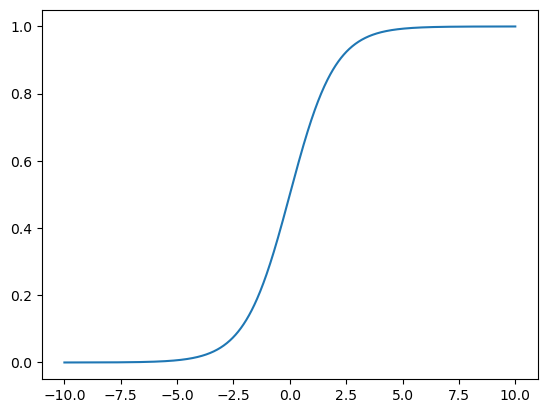

non-jit version:
895 µs ± 10.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
jit version:
210 µs ± 9.75 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [24]:
# Define the sigmoid activation function - used in NN and classification problems
def sigmoid(x):
    return 1/(1 + jnp.exp(-x))

# Visualize sigmoid
visualize_fn(sigmoid)

sigmoid_jit = jit(sigmoid)  # let's jit it

# Benchmark non-jit vs jit version
data = random.normal(key, (1000000,))

print('non-jit version:')
%timeit sigmoid(data).block_until_ready()
print('jit version:')
%timeit sigmoid_jit(data).block_until_ready()

### Tracing mechanism and its limitations

JIT and other JAX transforms work by _tracing_ a function to determine its effect on inputs of a specific shape and type.

In [25]:
@jit # we can use jit as a decorator, instead of calling it as a function
def f(x, y):
    print("Running f():")
    print(f"  x = {x}")
    print(f"  y = {y}")
    result = jnp.dot(x + 1, y + 1)
    print(f"  result = {result}")
    return result

x = np.random.randn(3, 4)
y = np.random.randn(4)
print(f(x, y))

x2 = np.random.randn(3, 4)
y2 = np.random.randn(4)
print('Second call:')
print(f(x2, y2))  # Oops! Side effects (like print) are not compiled...

Running f():
  x = Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace(level=1/0)>
  y = Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=1/0)>
  result = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>
[2.6163206  0.96163666 2.00492   ]
Second call:
[14.913197   2.7248204  8.626188 ]


Notice that the print statements execute, but rather than printing the data we passed to the function, though, it prints tracer objects that stand-in for them.

These tracer objects are what `jit` uses to extract the sequence of operations specified by the function. This recorded sequence of computations can then be efficiently applied within XLA to new inputs with the same shape and dtype, without having to re-execute the Python code. Tracers are placeholders that encode the shape and dtype of the arrays, but are independent of their values. 

JAX has its own intermediate representation for sequences of operations, known as a `jaxpr`. A `jaxpr` (short for JAX exPRession) is a simple representation of a functional program, comprising a sequence of primitive operations. We can use `jax.make_jaxpr()` to inspect the `jaxpr` associated to a jit-compiled function.

In [26]:
# Same function as above just without the print statements
def f(x, y):
    return jnp.dot(x + 1, y + 1)

print(make_jaxpr(f)(x, y))

{ lambda ; a:f32[3,4] b:f32[4]. let
    c:f32[3,4] = add a 1.0
    d:f32[4] = add b 1.0
    e:f32[3] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c d
  in (e,) }


A consequence of the tracing mechanism is that not all JAX code can be JIT compiled, as it requires array shapes to be **static** & **known at compile time**.

In [27]:
# Example of a failure: array shapes must be static

def get_negatives(x):
    return x[x < 0]

x = random.normal(key, (10,), dtype=jnp.float32)
print(get_negatives(x))
print(jit(get_negatives)(x))

[-0.36259937 -0.04603493 -0.18834311 -0.17379811 -0.6568317 ]


NonConcreteBooleanIndexError: Array boolean indices must be concrete; got ShapedArray(bool[10])

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError

In [28]:
# 2nd example of a failure:

@jit
def f(x, neg):  # depends on the value - remember tracer cares about shapes and types!
    return -x if neg else x

f(1, True)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function f at /var/folders/6x/8nyd9hnd0n9dtx4st6g2d5zj_v2dvq/T/ipykernel_86030/326596064.py:3 for jit. This concrete value was not available in Python because it depends on the value of the argument neg.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [29]:
# Workaround: the "static" arguments

from functools import partial

@partial(jit, static_argnums=(1,))
def f(x, neg):
    return -x if neg else x

print(f(1, True))
print(f(2, True))
print(f(2, False))
print(f(23, False))

-1
-2
2
23


Note that calling a JIT-compiled function with a different static argument results in re-compilation, so pay attention if you need to call this function with many different values (not a good idea). Static operations are evaluated at compile-time in Python; traced operations are compiled & evaluated at run-time in XLA.

In [30]:
# Another example: range depends on value again

def f(x, n):
    y = 0.
    for i in range(n):
        y = y + x[i]
    return y

f_jit = jit(f, static_argnums=(1,))
x = (jnp.array([2., 3., 4.]), 5)

print(f_jit(*x))


17.0


In [31]:
# 3rd example of a failure:

@jit
def f(x):
    # print(jnp.array(x.shape).prod())
    return x.reshape(jnp.array(x.shape).prod())

x = jnp.ones((2, 3))
f(x)

TypeError: Shapes must be 1D sequences of concrete values of integer type, got [Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=1/0)>].
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.
The error occurred while tracing the function f at /var/folders/6x/8nyd9hnd0n9dtx4st6g2d5zj_v2dvq/T/ipykernel_86030/1464064528.py:3 for jit. This value became a tracer due to JAX operations on these lines:

  operation a[35m:i32[2][39m = convert_element_type[new_dtype=int32 weak_type=False] b
    from line /var/folders/6x/8nyd9hnd0n9dtx4st6g2d5zj_v2dvq/T/ipykernel_86030/1464064528.py:6:21 (f)

In [32]:
# Workaround: using numpy instead of jax.numpy

@jit
def f(x):
    return x.reshape((np.prod(x.shape),))

f(x)

Array([1., 1., 1., 1., 1., 1.], dtype=float32)

- JAX is designed to work only with **pure functions**.

Informal definition:

1. All the input data is passed through the function parameters, all the results are output through the function results.
2. A pure function will always return the same result if invoked with the same inputs.

In [33]:
# Example 1

def impure_print_side_effect(x):
    print("Executing function")  # Violating #1
    return x

# The side-effects appear during the first run 
print ("First call: ", jit(impure_print_side_effect)(4.))

# Subsequent runs with parameters of same type and shape may not show the side-effect
# This is because JAX now invokes a cached compiled version of the function
print ("Second call: ", jit(impure_print_side_effect)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
print ("Third call, different type: ", jit(impure_print_side_effect)(jnp.array([5.])))

Executing function
First call:  4.0
Second call:  5.0
Executing function
Third call, different type:  [5.]


In [34]:
# Example 2

g = 0.

def impure_uses_globals(x):
    return x + g  # Violating both #1 and #2

# JAX captures the value of the global during the first run
print ("First call: ", jit(impure_uses_globals)(4.))

# Let's update the global!
g = 10.

# Subsequent runs may silently use the cached value of the globals
print ("Second call: ", jit(impure_uses_globals)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
# This will end up reading the latest value of the global
print ("Third call, different type: ", jit(impure_uses_globals)(jnp.array([4.])))

First call:  4.0
Second call:  5.0
Third call, different type:  [14.]


# Exercises

### Exercise 1: gradient descent optimization

In [35]:
import jax
import jax.numpy as jnp
from jax import grad, jit

# Generate synthetic data
key = jax.random.PRNGKey(0)
true_w = jnp.array([2.0, -3.0])  # True weights for the synthetic data
true_b = 5.0  # True bias for the synthetic data
num_samples = 100
x = jax.random.normal(key, (num_samples, 2))  # Input features
y = jnp.dot(x, true_w) + true_b  # Targets

# Define the model
def model(weights, biases, x):
    return jnp.dot(x, weights) + biases

# Mean squared error loss function
def mse_loss(weights, biases, x, y):
    predictions = model(weights, biases, x)
    return jnp.mean((predictions - y) ** 2)

# Gradient of the loss function
grad_mse_loss = grad(mse_loss, argnums=(0, 1))

# Training step
@jit
def train_step(weights, biases, x, y, learning_rate):
    gradients = grad_mse_loss(weights, biases, x, y)
    new_weights = weights - learning_rate * gradients[0]
    new_biases = biases - learning_rate * gradients[1]
    return new_weights, new_biases

# Initialize parameters
weights = jax.random.normal(key, (2,))
biases = 0.0
learning_rate = 0.01
num_epochs = 1000

# Training loop
for epoch in range(num_epochs):
    weights, biases = train_step(weights, biases, x, y, learning_rate)
    if epoch % 100 == 0:
        current_loss = mse_loss(weights, biases, x, y)
        print(f"Epoch {epoch}, Loss: {current_loss}")

# Print the final parameters
print("Learned weights:", weights)
print("Learned bias:", biases)

Epoch 0, Loss: 43.717899322509766
Epoch 100, Loss: 0.9514498710632324
Epoch 200, Loss: 0.022219862788915634
Epoch 300, Loss: 0.0005381536902859807
Epoch 400, Loss: 1.3314468560565729e-05
Epoch 500, Loss: 3.343974697145313e-07
Epoch 600, Loss: 8.454707156602126e-09
Epoch 700, Loss: 1.9122693706297156e-10
Epoch 800, Loss: 1.9122693706297156e-10
Epoch 900, Loss: 1.9122693706297156e-10
Learned weights: [ 1.9999996 -2.9999936]
Learned bias: 4.999987


**Bonus exercise**: use Optax https://github.com/google-deepmind/optax to solve the same optimization problem.

### Exercise 2: solving a non-linear system of equations.

In [44]:
import jax
import jax.numpy as jnp
from jax import jacfwd, jacrev
from scipy.optimize import root

# Define the system of nonlinear equations
@jit
def system_of_equations(x):
    # Example equations:
    # Equation 1: x0^2 + x1 - 37 = 0
    # Equation 2: x0 - x1^2 - 5 = 0
    return jnp.array([
        x[0]**2 + x[1] - 37,
        x[0] - x[1]**2 - 5
    ])

# Function to compute the Jacobian using JAX
@jit
def jacobian(x):
    return jax.jacfwd(system_of_equations)(x)

# Initial guess for the solution
initial_guess = jnp.array([1.0, 1.0])

# Use scipy's root function to find the solution
%timeit solution = root(system_of_equations, initial_guess, jac=jacobian)

# Print the solution
print("Solution:", solution.x)
print("Function value at solution:", system_of_equations(solution.x))
print("Jacobian at solution:", jacobian(solution.x))

8.42 ms ± 55.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Solution: [6. 1.]
Function value at solution: [0. 0.]
Jacobian at solution: [[12.  1.]
 [ 1. -2.]]
